In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
cali = fetch_california_housing()
df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
df['target'] = cali['target']
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [5]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

In [13]:
data = torch.from_numpy(df.values).float()
X = data[:, :-1]
y = data[:, -1:]

In [14]:
ratios = [0.6, 0.2, 0.2]

In [15]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

In [16]:
indices = torch.randperm(data.size(0))
X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
X = list(X.split(cnts, dim=0))
y = y.split(cnts, dim=0)

In [17]:
scaler = StandardScaler()
scaler.fit(X[0].numpy())
X[0] = torch.from_numpy(scaler.transform(X[0].numpy())).float()
X[1] = torch.from_numpy(scaler.transform(X[1].numpy())).float()
X[2] = torch.from_numpy(scaler.transform(X[2].numpy())).float()

In [19]:
model = nn.Sequential(
    nn.Linear(X[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1))
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [20]:
optimizer = optim.Adam(model.parameters())

In [21]:
n_epochs = 4000
batch_size = 256
print_interval = 400
#learning_rate = 1e-2

In [30]:
lowest_loss = np.inf
best_model = None
early_stop = 200
lowest_epoch = np.inf

In [31]:
train_history, valid_history = ([], [])

for i in range(n_epochs):
    indices = torch.randperm(X[0].size(0))
    X_ = torch.index_select(X[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    train_loss, valid_loss = (0, 0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = F.mse_loss(y_hat_i, y_i)
            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.4e}, valid loss={valid_loss:.4e}, lowest loss={lowest_loss:.4e}')
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4e}')

model.load_state_dict(best_model)

Epoch 400: train loss=2.8736e-01, valid loss=2.8279e-01, lowest loss=2.8152e-01
Epoch 800: train loss=2.8551e-01, valid loss=2.8374e-01, lowest loss=2.8036e-01
Epoch 1200: train loss=2.8512e-01, valid loss=2.8170e-01, lowest loss=2.7892e-01
Epoch 1600: train loss=2.8361e-01, valid loss=2.7866e-01, lowest loss=2.7808e-01
There is no improvement during last 200 epochs.
The best validation loss from epoch 1732: 2.7757e-01


<All keys matched successfully>

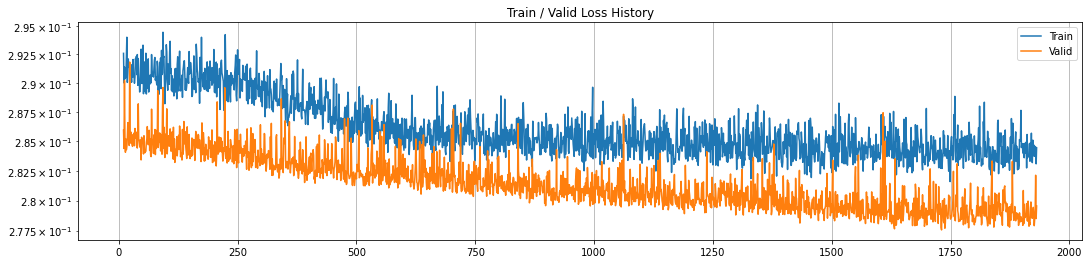

In [34]:
plot_from = 10

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [35]:
test_loss = 0
y_hat = []

with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4e}')
print(f'Valid loss: {sorted_history[0][1]:.4e}')
print(f'Test loss: {test_loss:.4e}')

Train loss: 2.8388e-01
Valid loss: 2.7757e-01
Test loss: 3.0888e-01
